In [10]:
import os
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
import seaborn as sns
import pickle

In [12]:
# Specify the input directory
input_directory = "../Dataset/Foto_Resize_Rotate_50x50" 

# List folders and create a label mapping
folders = [f for f in os.listdir(input_directory) if os.path.isdir(os.path.join(input_directory, f))]
print(f"Found folders: {folders}")

# Initialize arrays for inputs (X) and labels (y)
X, y = [], []
label_map = {folder: idx for idx, folder in enumerate(folders)}
num_classes = len(folders)

# Process each image in each folder
for folder in folders:
    folder_path = os.path.join(input_directory, folder)
    photos = sorted([p for p in os.listdir(folder_path) if p.endswith(('.png', '.jpg', '.jpeg'))])

    for photo in photos:
        photo_path = os.path.join(folder_path, photo)
        image = Image.open(photo_path)
        image_array = np.array(image).flatten()  # Flatten image to 1D array
        X.append(image_array)

        # Create one-hot encoded label
        label = np.zeros(num_classes)
        label[label_map[folder]] = 1
        y.append(label)

# Convert X and y to numpy arrays
X = np.array(X)
y = np.array(y)

# Normalize the input data (X)
X_normalized = X / 255

# Combine X and y into a single array
combined_array = np.hstack((X_normalized, y))

# Split data into training, testing, and validation sets
np.random.shuffle(combined_array)
num_samples = combined_array.shape[0]
train_end = int(0.7 * num_samples)  # 70% for training
test_end = int(0.85 * num_samples)  # 15% for testing

train_data = combined_array[:train_end]
test_data = combined_array[train_end:test_end]
val_data = combined_array[test_end:]

# Separate inputs and outputs for each dataset
X_train, y_train = train_data[:, :-num_classes], train_data[:, -num_classes:]
X_test, y_test = test_data[:, :-num_classes], test_data[:, -num_classes:]
X_val, y_val = val_data[:, :-num_classes], val_data[:, -num_classes:]

# Display the shape of the datasets
print("Training data:", X_train.shape, y_train.shape)
print("Testing data:", X_test.shape, y_test.shape)
print("Validation data:", X_val.shape, y_val.shape)

# Example of normalized input
print("Normalized training sample:", X_train[0])

Found folders: ['Azmira', 'David', 'Dimas', 'Fadhli', 'Fadlin', 'Hafidz', 'Haidar', 'Hanna', 'Keiko', 'Khansa', 'Mikhael', 'Puti', 'Raesa', 'Satwika', 'Toni']
Training data: (968, 2500) (968, 15)
Testing data: (208, 2500) (208, 15)
Validation data: (208, 2500) (208, 15)
Normalized training sample: [0.23529412 0.15686275 0.18431373 ... 0.83137255 0.82745098 0.82745098]


In [13]:
# Initialize the neural network

inputLayer = 2500
outputLayer = 15
epoch = 10000
lr = 0.001
X = X_train
T = y_train
neuron = 10
stoping_tr = 0.01

stddev = np.sqrt(2/inputLayer)


v = np.random.normal(loc=0, scale = stddev, size = (inputLayer, neuron))  # weights from input to hidden layer
print(np.shape(v))

vb = np.random.normal(loc=0, scale = stddev, size = (1, neuron)) # weight biases for hidden layer
print(np.shape(vb))

w = np.random.normal(loc=0, scale = stddev, size = (neuron, outputLayer)) # weights from hidden to output layer
print(np.shape(w))

wb = np.random.normal(loc=0, scale = stddev, size = (1, outputLayer)) # weight biases for output layer
print(np.shape(wb))


(2500, 10)
(1, 10)
(10, 15)
(1, 15)


In [14]:
# fungsi sigmoid
def sigmoid(x):
    return 1 / (1 + np.exp(-x))

def d_sigmoid(x):
    return sigmoid(x) * (1 - sigmoid(x))

# fungsi RELu
def relu(x):
    return np.maximum(0, x)

def d_relu(x):
    return np.where(x > 0, 1, 0)

# fungsi softmax
def softmax(x):
    exps = np.exp(x - np.max(x))  # Stabilize softmax by subtracting max
    return exps / np.sum(exps)

In [15]:
def feedForward(x, v, vb, w, wb):
    # sinyal unit hidden
    z_in = np.dot(x, v) + vb   # sinyal input unit hidden
    z = relu(z_in)             # sinyal output unit hidden dengan f.aktivasi

    # sinyal unit output
    y_in = np.dot(z, w) + wb   # sinyal input unit output
    y = softmax(y_in)          # sinyal output unit output dengan f.aktivasi


    # Flatten activation to avoid shape issues
    z_in = z_in.flatten()
    z = z.flatten()
    y_in = y_in.flatten()
    y = y.flatten()

    return z_in, z, y_in, y

In [16]:
def backPropagation(x, t, z, z_in, y, y_in, v, vb, w, wb, NH, NO, lr):
    delta_y = (t - y)                   # error unit output
    del_w = lr * np.outer(z, delta_y)   # koreksi bobot unit output
    del_wb = lr * delta_y               # koreksi bobot bias unit output

    delta_zin = np.dot(delta_y, w.T)    # error unit hidden
    delta_z = delta_zin * d_relu(z_in)  # aktivasi koreksi error unit hidden
    del_v = lr * np.outer(x, delta_z)   # koreksi bobot unit hidden
    del_vb = lr * delta_z               # koreksi bobot bias unit hidden

    # update bobot dan bias unit output
    w += del_w
    wb += del_wb

    # update bobot dan bias unit hedden
    v += del_v
    vb += del_vb

    return v, vb, w, wb

In [17]:
error_log = []
val_error_log = []
patience_counter = 0
patience = 100
best_val_error = float('inf')
flag = True

for e in range(epoch):
    # Training phase
    total_error_cross_entropy_train = 0
    for i in range(len(X_train)):
        x = X_train[i]
        t = y_train[i]

        # Forward and backward pass
        z_in, z, y_in, y = feedForward(x, v, vb, w, wb)
        v, vb, w, wb = backPropagation(x, t, z, z_in, y, y_in, v, vb, w, wb, neuron, outputLayer, lr)

        # Compute training error (cross-entropy loss)
        cross_entropy_train = -np.sum(t * np.log(y + 1e-15))
        total_error_cross_entropy_train += cross_entropy_train

    avg_train_error = total_error_cross_entropy_train / len(X_train)
    error_log.append(avg_train_error)

    # Validation phase
    total_error_cross_entropy_val = 0
    for i in range(len(X_val)):
        x = X_val[i]
        t = y_val[i]

        # Forward pass for validation
        _, _, _, y = feedForward(x, v, vb, w, wb)

        # Compute validation error (cross-entropy loss)
        cross_entropy_val = -np.sum(t * np.log(y + 1e-15))
        total_error_cross_entropy_val += cross_entropy_val

    avg_val_error = total_error_cross_entropy_val / len(X_val)
    val_error_log.append(avg_val_error)

    # Logging
    if e % 10 == 0 or e == epoch - 1:
        print(f"Epoch: {e + 1}/{epoch}, Train Error: {avg_train_error:.5f}, Val Error: {avg_val_error:.5f}")

    # Early stopping check
    if avg_val_error < best_val_error:
        best_val_error = avg_val_error
        patience_counter = 0  # Reset patience counter if validation error improves
        best_weights = (v.copy(), vb.copy(), w.copy(), wb.copy())
    else:
        patience_counter += 1

    if patience_counter > patience and avg_train_error < 0.01:
        print(f"Early stopping triggered at epoch {e + 1}. Best Validation Error: {best_val_error:.4f}, Train Error: {avg_train_error:.5f}.")
        # Restore the best weights
        v, vb, w, wb = best_weights
        break


Epoch: 1/10000, Train Error: 2.69523, Val Error: 2.69613
Epoch: 11/10000, Train Error: 1.85512, Val Error: 1.91256
Epoch: 21/10000, Train Error: 1.07423, Val Error: 1.18014
Epoch: 31/10000, Train Error: 0.73557, Val Error: 0.88404
Epoch: 41/10000, Train Error: 0.54850, Val Error: 0.74436
Epoch: 51/10000, Train Error: 0.41883, Val Error: 0.65308
Epoch: 61/10000, Train Error: 0.32128, Val Error: 0.59096
Epoch: 71/10000, Train Error: 0.24719, Val Error: 0.56198
Epoch: 81/10000, Train Error: 0.19007, Val Error: 0.55501
Epoch: 91/10000, Train Error: 0.14610, Val Error: 0.55724
Epoch: 101/10000, Train Error: 0.11403, Val Error: 0.56736
Epoch: 111/10000, Train Error: 0.09028, Val Error: 0.58322
Epoch: 121/10000, Train Error: 0.07347, Val Error: 0.59813
Epoch: 131/10000, Train Error: 0.06125, Val Error: 0.61075
Epoch: 141/10000, Train Error: 0.05167, Val Error: 0.62387
Epoch: 151/10000, Train Error: 0.04412, Val Error: 0.63427
Epoch: 161/10000, Train Error: 0.03866, Val Error: 0.64364
Epoch: 1

In [18]:
def save_model(file_path, v, vb, w, wb):
    model_data = {'v': v, 'vb': vb, 'w': w, 'wb': wb}
    with open(file_path, 'wb') as file:
        pickle.dump(model_data, file)
    print(f"Model saved to {file_path}")

save_model("model_vectoral_50x50.pkl", v, vb, w, wb)


Model saved to model_vectoral_50x50.pkl


Testing Accuracy: 88.46%


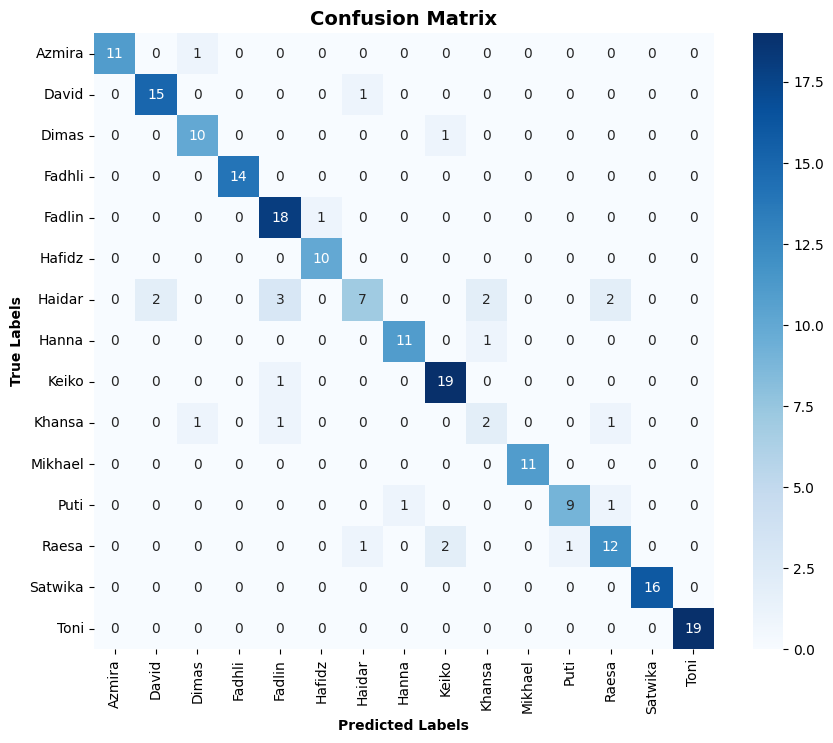

Classification Report:
              precision    recall  f1-score   support

      Azmira       1.00      0.92      0.96        12
       David       0.88      0.94      0.91        16
       Dimas       0.83      0.91      0.87        11
      Fadhli       1.00      1.00      1.00        14
      Fadlin       0.78      0.95      0.86        19
      Hafidz       0.91      1.00      0.95        10
      Haidar       0.78      0.44      0.56        16
       Hanna       0.92      0.92      0.92        12
       Keiko       0.86      0.95      0.90        20
      Khansa       0.40      0.40      0.40         5
     Mikhael       1.00      1.00      1.00        11
        Puti       0.90      0.82      0.86        11
       Raesa       0.75      0.75      0.75        16
     Satwika       1.00      1.00      1.00        16
        Toni       1.00      1.00      1.00        19

    accuracy                           0.88       208
   macro avg       0.87      0.87      0.86       208
wei

In [19]:
# Calculate predictions
y_preds = []
for x in X_test:
    _, _, _, y = feedForward(x, v, vb, w, wb)
    y_preds.append(np.argmax(y))  # Predict class based on softmax output

# Calculate Accuracy
accuracy = accuracy_score(np.argmax(y_test, axis=1), y_preds)
print(f"Testing Accuracy: {accuracy:.2%}")

# Calculate Confusion Matrix
cm = confusion_matrix(np.argmax(y_test, axis=1), y_preds)

# Visualize Confusion Matrix
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", 
            xticklabels=folders, yticklabels=folders)
plt.xlabel("Predicted Labels", weight='bold')
plt.ylabel("True Labels", weight='bold')
plt.title("Confusion Matrix", fontsize=14, weight='bold')
plt.show()

# Classification Report
print("Classification Report:")
print(classification_report(np.argmax(y_test, axis=1), y_preds, target_names=folders))
